In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

df=pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
df_cycles=df[df['INSPECTION TYPE'].str.contains('Cycle',regex=False, na=False)]
df_cycles['INSPECTION DATE']=pd.to_datetime(df['INSPECTION DATE'])


C:\Users\kosta\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


there are many types of inspection performed by the Department of Health and Mental Hygene but we will concern ourselvs only with the cycle inspections performed for food saftey and grade assignment

In [9]:
df_cycles.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

In [10]:
df_cycles.ACTION.value_counts()

Violations were cited in the following area(s).                                                                                        307283
Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.     11632
Establishment re-opened by DOHMH                                                                                                         3309
Establishment re-closed by DOHMH                                                                                                          869
No violations were recorded at the time of this inspection.                                                                               737
Name: ACTION, dtype: int64

In [11]:
#handful of inspections received a a socre of -1 - impossible
df_cycles=df_cycles.loc[df_cycles['SCORE']>=0]
drop_impossible=df_cycles.loc[(df_cycles['SCORE']==0)&(df_cycles['VIOLATION CODE'].isna()==False)].index
df_cycles=df_cycles.drop(index=drop_impossible)

In [12]:
df_cycles.to_csv('cycles.csv')

In [13]:
CAMIS=df_cycles.CAMIS.unique()
#construct dictionary of individual inspections at establishment
rest_inspection_dates={}
for cam in CAMIS:
    rest_inspection_dates[cam]=df_cycles.loc[df_cycles['CAMIS']==cam]['INSPECTION DATE'].unique()


In [14]:
#turn each into equal length arrays of CAMIS an inspection date   
cam2=[]
date2=[]
for cam in CAMIS:
    for date in rest_inspection_dates[cam]:
        cam2.append(cam)
        date2.append(date)
#turn each into equal length arrays of CAMIS and inspection date        
print(len(cam2))
print(len(date2))

112272
112272


In [15]:
df_inspections=pd.DataFrame()
df_inspections['CAMIS']=cam2
df_inspections['DATE']=pd.to_datetime(date2)
df_inspections=df_inspections.sort_values(['CAMIS','DATE'])

add columns to inspection data frame for inspection type, violations, score,

In [16]:
score=[]
for c, d in zip(df_inspections['CAMIS'],df_inspections['DATE']):
    score.append(df_cycles.loc[df_cycles['CAMIS']==c].loc[df_cycles['INSPECTION DATE']==d]['SCORE'].iloc[0])


In [17]:
df_inspections['SCORE']=score
df_inspections.head()

,CAMIS,DATE,SCORE
93905,30075445,2017-05-18,7.0
93904,30075445,2018-05-11,5.0
93907,30075445,2019-05-16,14.0
93906,30075445,2019-06-11,6.0
93367,30112340,2016-04-12,0.0


In [18]:
ins_type=[]
for c, d in zip(df_inspections['CAMIS'],df_inspections['DATE']):
    ins_type.append(df_cycles.loc[df_cycles['CAMIS']==c].loc[df_cycles['INSPECTION DATE']==d]['INSPECTION TYPE'].iloc[0])
df_inspections['INSPECTION TYPE']=ins_type
df_inspections.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection
93906,30075445,2019-06-11,6.0,Cycle Inspection / Re-inspection
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection


In [19]:
sorted(df_cycles['VIOLATION CODE'].dropna().unique())

['02A',
 '02B',
 '02C',
 '02D',
 '02E',
 '02F',
 '02G',
 '02H',
 '02I',
 '02J',
 '03A',
 '03B',
 '03C',
 '03D',
 '03E',
 '03F',
 '03G',
 '04A',
 '04B',
 '04C',
 '04D',
 '04E',
 '04F',
 '04G',
 '04H',
 '04I',
 '04J',
 '04K',
 '04L',
 '04M',
 '04N',
 '04O',
 '05A',
 '05B',
 '05C',
 '05D',
 '05E',
 '05F',
 '05H',
 '06A',
 '06B',
 '06C',
 '06D',
 '06E',
 '06F',
 '06G',
 '06H',
 '06I',
 '07A',
 '08A',
 '08B',
 '08C',
 '09A',
 '09B',
 '09C',
 '10A',
 '10B',
 '10C',
 '10D',
 '10E',
 '10F',
 '10G',
 '10H',
 '10I',
 '10J',
 '17A1',
 '17A3',
 '19A1',
 '19A3',
 '22F',
 '22G']

Full list of codes and descriptions is available in the "blue book" https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf . Some of these codes are not in that list and all of those that are not valid codes are missing the Violation Description as well. These are dropped from the dataset.

In [20]:
for v in sorted(df_cycles['VIOLATION CODE'].dropna().unique())[-6:]:
    print(len(df_cycles.loc[df_cycles['VIOLATION CODE']==v]['VIOLATION DESCRIPTION']))

2
1
1
1
421
698


In [21]:
vio_codes=sorted(df_cycles['VIOLATION CODE'].dropna().unique())[:-6]

In [22]:
for v in vio_codes:
    temp=[]
    for c, d in zip(df_inspections['CAMIS'],df_inspections['DATE']):
        #sum of true and falses. should only every be 1 or 0
        temp.append(sum(df_cycles.loc[df_cycles['CAMIS']==c].loc[df_cycles['INSPECTION DATE']==d]['VIOLATION CODE'].str.contains(v)))
        
    df_inspections[v]=temp

In [23]:
df_inspections.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE,02A,02B,02C,02D,02E,02F,...,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93906,30075445,2019-06-11,6.0,Cycle Inspection / Re-inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
ins_act=[]
for c, d in zip(df_inspections['CAMIS'],df_inspections['DATE']):
    ins_act.append(df_cycles.loc[df_cycles['CAMIS']==c].loc[df_cycles['INSPECTION DATE']==d]['ACTION'].iloc[0])
df_inspections['ACTION']=ins_act
df_inspections.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE,02A,02B,02C,02D,02E,02F,...,10B,10C,10D,10E,10F,10G,10H,10I,10J,ACTION
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93906,30075445,2019-06-11,6.0,Cycle Inspection / Re-inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No violations were recorded at the time of thi...


In [25]:
df_inspections.fillna(0,inplace=True)
df_inspections.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE,02A,02B,02C,02D,02E,02F,...,10B,10C,10D,10E,10F,10G,10H,10I,10J,ACTION
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93906,30075445,2019-06-11,6.0,Cycle Inspection / Re-inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No violations were recorded at the time of thi...


In [26]:
crit=[]
for c, d in zip(df_inspections['CAMIS'],df_inspections['DATE']):
    crit.append(sum(df_cycles.loc[df_cycles['CAMIS']==c].loc[df_cycles['INSPECTION DATE']==d]['CRITICAL FLAG']=='Y'))
df_inspections['CRITICAL FLAG']=crit
df_inspections.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE,02A,02B,02C,02D,02E,02F,...,10C,10D,10E,10F,10G,10H,10I,10J,ACTION,CRITICAL FLAG
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,1
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,0
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,1
93906,30075445,2019-06-11,6.0,Cycle Inspection / Re-inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,0
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No violations were recorded at the time of thi...,0


In [27]:
grade=[]
for score in df_inspections['SCORE']:
    if score <=13:
        grade.append('A')
    elif score >= 28:
        grade.append('C')
    else:
        grade.append('B')
df_inspections['GRADE']=grade
df_inspections.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE,02A,02B,02C,02D,02E,02F,...,10D,10E,10F,10G,10H,10I,10J,ACTION,CRITICAL FLAG,GRADE
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,1,A
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,0,A
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,1,B
93906,30075445,2019-06-11,6.0,Cycle Inspection / Re-inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,0,A
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No violations were recorded at the time of thi...,0,A


In [28]:
df_inspections['GRADE'].value_counts(normalize=True)

A    0.658900
B    0.237174
C    0.103926
Name: GRADE, dtype: float64

In [29]:
df_inspections.to_csv('inspections.csv')

In [30]:
df_init=df_inspections[df_inspections['INSPECTION TYPE'].str.contains('Initial',regex=False)]
df_init.head()

,CAMIS,DATE,SCORE,INSPECTION TYPE,02A,02B,02C,02D,02E,02F,...,10D,10E,10F,10G,10H,10I,10J,ACTION,CRITICAL FLAG,GRADE
93905,30075445,2017-05-18,7.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,1,A
93904,30075445,2018-05-11,5.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,0,A
93907,30075445,2019-05-16,14.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,1,B
93367,30112340,2016-04-12,0.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No violations were recorded at the time of thi...,0,A
93360,30112340,2016-10-03,48.0,Cycle Inspection / Initial Inspection,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Violations were cited in the following area(s).,3,C


C:\Users\kosta\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


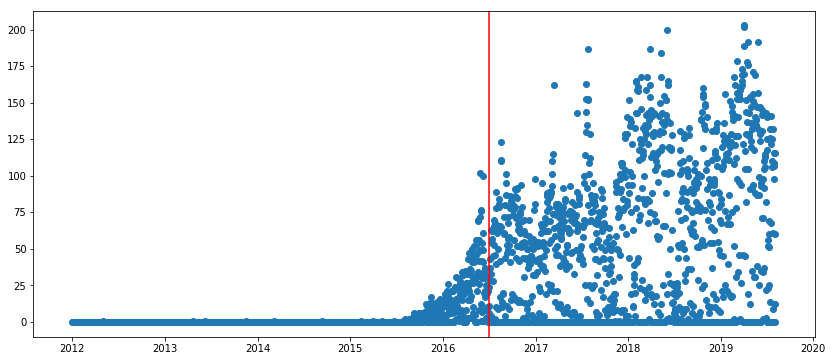

In [31]:
count=[]
for day in pd.date_range('2012-01-01','2019-08-05'):
    count.append(len(df_init.loc[df_init['DATE']==day]))
plt.figure(figsize=(14,6))
plt.scatter(pd.date_range('2012-01-01','2019-08-05'),count)
plt.axvline(pd.to_datetime('2016/07/1'),color='r')

Very sparse prior to mid 2016, take data only from 1st of July 2016 onward

In [32]:
df_init=df_init.loc[df_init['DATE']>'2016-07-01']

In [33]:
print('inspections in year 2016: ',len(df_init.loc[(df_init['DATE']<'2017')&(df_init['DATE']>'2016')]),'(half year)')
print('inspections in year 2017: ',len(df_init.loc[(df_init['DATE']<'2018')&(df_init['DATE']>'2017')]))
print('inspections in year 2018: ',len(df_init.loc[(df_init['DATE']<'2019')&(df_init['DATE']>'2018')]))
print('inspections in year 2019: ',len(df_init.loc[df_init['DATE']>'2019']),'(half year)')

inspections in year 2016:  7640 (half year)
inspections in year 2017:  17577
inspections in year 2018:  24987
inspections in year 2019:  19454 (half year)


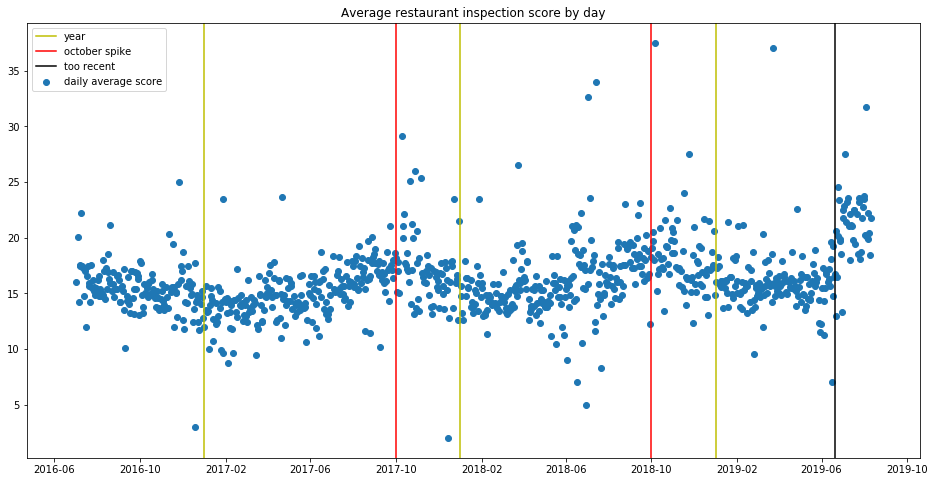

In [34]:
#monthly mean score awarded - time based bias?
plt.figure(figsize=(16,8))
plt.scatter(df_init.groupby('DATE')['SCORE'].mean().index,df_init.groupby('DATE')['SCORE'].mean(),label='daily average score')
plt.title('Average restaurant inspection score by day')
#annual lines
plt.axvline(pd.to_datetime('2017'),color='y',label='year')

plt.axvline(pd.to_datetime('2018'),color='y')
plt.axvline(pd.to_datetime('2019'),color='y')
#october?
# plt.axvline(pd.to_datetime('2016/10/1'),color='r')
plt.axvline(pd.to_datetime('2017/10/1'),color='r',label='october spike')
plt.axvline(pd.to_datetime('2018/10/1'),color='r')
plt.axvline(pd.to_datetime('2019/6/20'),color='black',label='too recent')
plt.legend()
plt.show()

Inspection violations are regularly challenged, inspections occurring too recently have not had time to go throught adjudiction process and are significantly higher, take inspections from prior to the 20th of June 2019

In [35]:
df_init=df_init.loc[df_init['DATE']<'2019-06-20']

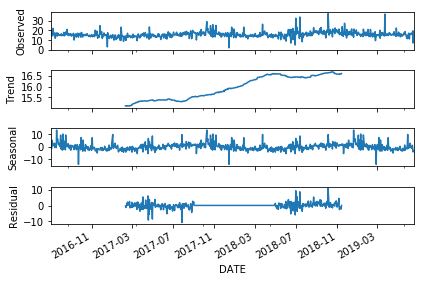

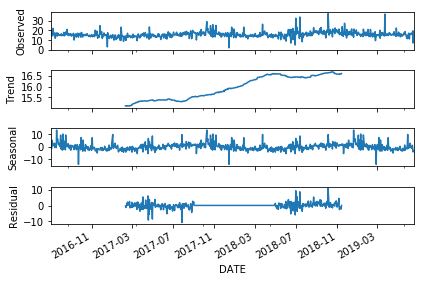

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df_init.groupby('DATE')['SCORE'].mean(),freq=365)

result.plot()

In [36]:
df_init.to_csv('initial.csv')